In [156]:
# Importando bibliotecas padrão
import joblib  # Para salvar e carregar modelos
import pandas as pd  # Para manipulação de dados
import numpy as np  # Para operações numéricas
import matplotlib.pyplot as plt  # Para criação de gráficos
import seaborn as sns  # Para visualização de dados
import warnings  # Para controlar mensagens de aviso

# Importando módulos de machine learning da biblioteca scikit-learn
from sklearn.model_selection import train_test_split  # Para dividir o dataset em treino e teste
from sklearn.model_selection import GridSearchCV  # Para realizar busca em grid para otimização de hiperparâmetros
from sklearn.model_selection import cross_val_score  # Para avaliação cruzada
from sklearn.model_selection import KFold  # Para criar dobras para validação cruzada
from sklearn.metrics import accuracy_score  # Para calcular a acurácia dos modelos
from sklearn.metrics import ConfusionMatrixDisplay  # Para exibir a matriz de confusão de forma gráfica
from sklearn.metrics import confusion_matrix  # Para calcular a matriz de confusão
from sklearn.tree import DecisionTreeClassifier  # Para classificação usando árvores de decisão
from sklearn.ensemble import RandomForestClassifier  # Para classificação usando florestas aleatórias
from sklearn.neighbors import KNeighborsClassifier  # Para classificação usando k-vizinhos mais próximos
from sklearn.linear_model import LogisticRegression  # Para regressão logística
from sklearn.svm import SVC  # Para máquinas de vetores de suporte
from sklearn.neural_network import MLPClassifier  # Para classificação usando redes neurais multicamadas
from sklearn.exceptions import ConvergenceWarning # Para controlar mensagens de aviso ConvergenceWarnings

# Importando módulo de estatística
from scipy.stats import shapiro  # Para teste de normalidade de Shapiro-Wilk

In [132]:
# Caminho relativo a partir do diretório onde o script está localizado
df = joblib.load('../data/processed/dados_processados.pkl')

In [133]:
# Selecionando as features que mais correlacionam
entradas = df[['forma-do-caule', 'raiz-do-caule', 'odor','habitat', 'cor-do-chapéu', 'forma-do-chapéu', 'número-do-anel','cor-do-velo']]
categoria = df['classe']
print(f"Formato das tabelas de dados {entradas.shape} e características dos cogumelos {categoria.shape}")

Formato das tabelas de dados (8124, 8) e características dos cogumelos (8124,)


In [134]:
# Separamos 20% para o teste
entradas_treino, entradas_teste, categoria_treino, categoria_teste = train_test_split(entradas, categoria, test_size=0.2)

print(f"Formato das tabelas de dados de treino {entradas_treino.shape} e teste {entradas_teste.shape}")

Formato das tabelas de dados de treino (6499, 8) e teste (1625, 8)


### Preparação dos dados

In [135]:
# Concatena os dados de 'entradas_treino' e 'entradas_teste' ao longo do eixo 0 (verticamente), formando um único array 'x_mushroom'
x_mushroom = np.concatenate((entradas_treino, entradas_teste), axis=0)

# Exibe as dimensões do array 'x_mushroom'
x_mushroom.shape

(8124, 8)

In [136]:
x_mushroom

array([[0, 1, 0, ..., 2, 1, 2],
       [0, 0, 4, ..., 2, 1, 2],
       [0, 0, 4, ..., 3, 1, 2],
       ...,
       [1, 0, 6, ..., 2, 1, 2],
       [0, 1, 0, ..., 0, 1, 2],
       [1, 3, 6, ..., 3, 1, 2]])

In [137]:
# Concatena os dados de 'categoria_treino' e 'categoria_teste' ao longo do eixo 0 (verticamente), formando um único array 'y_mushroom'
y_mushroom = np.concatenate((categoria_treino, categoria_teste), axis=0)

# Exibe as dimensões do array 'y_mushroom'
y_mushroom.shape

(8124,)

In [138]:
y_mushroom

array([1, 2, 2, ..., 1, 1, 1])

### Árvore de Decisão

In [139]:
parametros = {  # Dicionário contendo a grade de hiperparâmetros para busca
    'criterion': ['gini', 'entropy'],  # Critério para medir a qualidade da divisão (Gini ou Entropy)
    'splitter': ['best', 'random'],  # Estratégia para escolher a divisão em cada nó (Melhor ou Aleatória)
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 5, 10]  # Número mínimo de amostras necessárias para estar em um nó folha
}


In [140]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)  # Cria o GridSearchCV com DecisionTreeClassifier como estimador e o dicionário 'parametros' como grade de hiperparâmetros
grid_search.fit(x_mushroom, y_mushroom)  # Ajusta o grid_search aos dados de treinamento, buscando a melhor combinação de hiperparâmetros
melhores_parametros = grid_search.best_params_  # Obtém os melhores hiperparâmetros encontrados pelo GridSearchCV
melhor_resultado = grid_search.best_score_  # Obtém a melhor pontuação de desempenho alcançada durante a busca
print(melhores_parametros)  # Imprime os melhores hiperparâmetros
print(melhor_resultado)  # Imprime a melhor pontuação de desempenho (acurácia)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
1.0


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Definir o intervalo de valores para k
k_range = list(range(1, 26))
acertos = []

# Loop para testar diferentes valores de k
for k in k_range:
    modelo = KNeighborsClassifier(n_neighbors=k)
    modelo.fit(entradas_treino, categoria_treino)
    categoria_encontradas = modelo.predict(entradas_teste)
    acertos.append(accuracy_score(categoria_teste, categoria_encontradas))

# Plotar a taxa de acertos em função do valor de k
plt.plot(k_range, acertos, marker='o')
plt.xlabel('Valor de k do KNN')
plt.ylabel('Taxa de acertos')
plt.title('Taxa de acertos x valor de k do KNN')
plt.show()


### Random Forest

In [26]:
parametros = {  # Define um dicionário chamado 'parametros' para armazenar as combinações de hiperparâmetros a serem testadas
    'criterion': ['gini', 'entropy'],  # Define a métrica para medir a qualidade das divisões (gini ou entropy)
    'n_estimators': [10, 40, 100, 150],  # Número de árvores na floresta do RandomForestClassifier
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': [1, 5, 10]  # Número mínimo de amostras que um nó folha deve ter
}


In [27]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)  # Cria o GridSearchCV com RandomForestClassifier como estimador e o dicionário 'parametros' como grade de hiperparâmetros
grid_search.fit(x_mushroom, y_mushroom)  # Ajusta o grid_search aos dados de treinamento, buscando a melhor combinação de hiperparâmetros
melhores_parametros = grid_search.best_params_  # Obtém os melhores hiperparâmetros encontrados pelo GridSearchCV
melhor_resultado = grid_search.best_score_  # Obtém a melhor pontuação de desempenho alcançada durante a busca
print(melhores_parametros)  # Imprime os melhores hiperparâmetros
print(melhor_resultado)  # Imprime a melhor pontuação de desempenho (acurácia)


{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
1.0


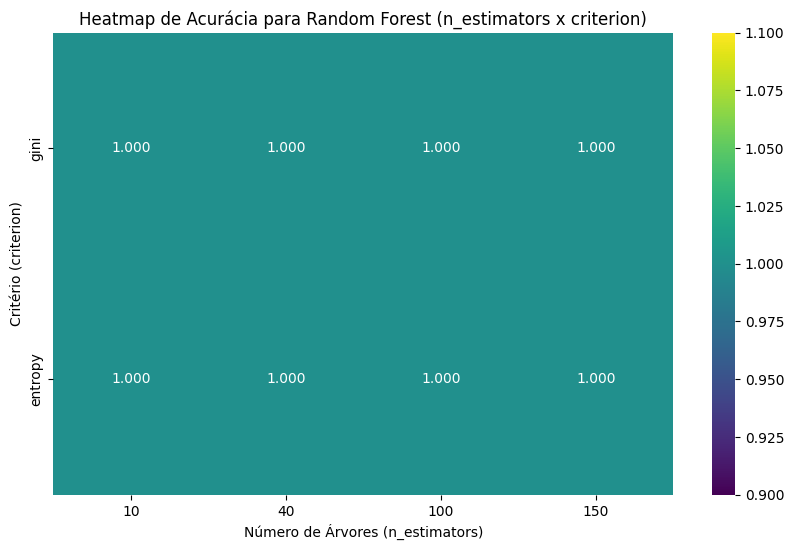

In [29]:
# Resultados do GridSearchCV
resultados_RF = grid_search.cv_results_

# Reshape considerando os 4 parâmetros ('criterion', 'n_estimators', 'min_samples_split', 'min_samples_leaf')
# Vamos simplificar para apenas 2 parâmetros para visualização em 2D: 'criterion' e 'n_estimators'
# Para isso, usaremos valores fixos para 'min_samples_split' e 'min_samples_leaf' para criar o gráfico
min_samples_split_fixed = 2  # Escolha um valor fixo para simplificação
min_samples_leaf_fixed = 1    # Escolha um valor fixo para simplificação

# Filtrar os resultados para os valores fixos de 'min_samples_split' e 'min_samples_leaf'
mask = (
    (resultados_RF['param_min_samples_split'] == min_samples_split_fixed) &
    (resultados_RF['param_min_samples_leaf'] == min_samples_leaf_fixed)
)
# Extraindo as pontuações médias para o heatmap
mean_scores = np.array(resultados_RF['mean_test_score'])[mask]

# Reshape para os hiperparâmetros 'criterion' e 'n_estimators'
scores = mean_scores.reshape(len(parametros['criterion']), len(parametros['n_estimators']))

# Plotar o heatmap para os resultados de 'criterion' e 'n_estimators'
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=parametros['n_estimators'], yticklabels=parametros['criterion'], cmap='viridis')
plt.title('Heatmap de Acurácia para Random Forest (n_estimators x criterion)')
plt.xlabel('Número de Árvores (n_estimators)')
plt.ylabel('Critério (criterion)')
plt.show()

### KNN

In [22]:
parametros = {  # Define um dicionário chamado 'parametros' para armazenar as combinações de hiperparâmetros a serem testadas
    'n_neighbors': [3, 5, 10, 20],  # Número de vizinhos a serem usados pelo algoritmo K-Nearest Neighbors (KNN)
    'p': [1, 2]  # Parâmetro da métrica de distância: 1 para Manhattan (L1), 2 para Euclidiana (L2)
}

In [23]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)  # Cria o GridSearchCV com KNeighborsClassifier como estimador e o dicionário 'parametros' como grade de hiperparâmetros
grid_search.fit(x_mushroom, y_mushroom)  # Ajusta o grid_search aos dados de treinamento, buscando a melhor combinação de hiperparâmetros
melhores_parametros = grid_search.best_params_  # Obtém os melhores hiperparâmetros encontrados pelo GridSearchCV
melhor_resultado = grid_search.best_score_  # Obtém a melhor pontuação de desempenho alcançada durante a busca
print(melhores_parametros)  # Imprime os melhores hiperparâmetros
print(melhor_resultado)  # Imprime a melhor pontuação de desempenho (acurácia)

{'n_neighbors': 3, 'p': 1}
1.0


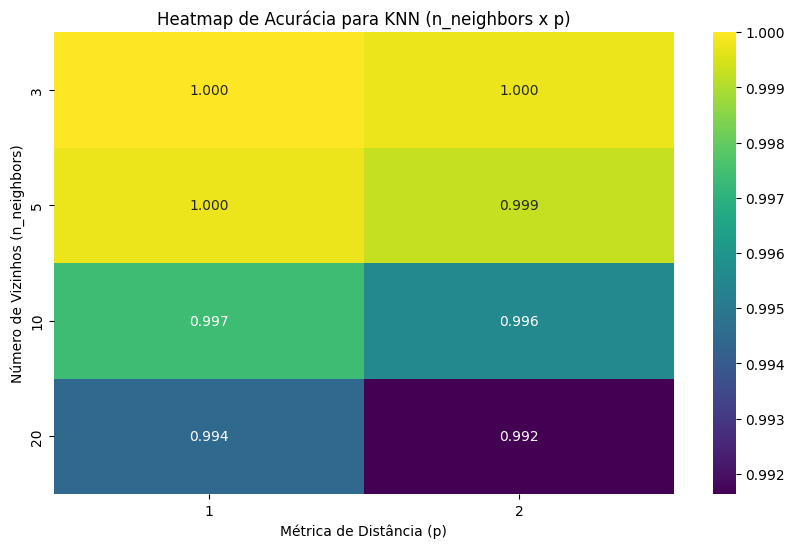

In [25]:
# Resultados do GridSearchCV
resultados_KNN = grid_search.cv_results_

# Reshape considerando os 2 parâmetros ('n_neighbors', 'p')
scores = np.array(resultados_KNN['mean_test_score']).reshape(len(parametros['n_neighbors']), len(parametros['p']))

# Criar o heatmap para visualizar os resultados
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=parametros['p'], yticklabels=parametros['n_neighbors'], cmap='viridis')
plt.title('Heatmap de Acurácia para KNN (n_neighbors x p)')
plt.xlabel('Métrica de Distância (p)')
plt.ylabel('Número de Vizinhos (n_neighbors)')
plt.show()

### Regressão Logística

In [142]:
parametros = {  # Define um dicionário chamado 'parametros' para armazenar as combinações de hiperparâmetros a serem testadas
    'tol': [0.0001, 0.00001, 0.000001],  # Tolerância para o critério de parada. Valores menores significam convergência mais precisa
    'C': [1.0, 1.5, 2.0],  # Parâmetro de regularização. Valores menores especificam uma regularização mais forte
    'solver': ['lbfgs', 'sag', 'saga'],  # Algoritmo de otimização a ser usado na resolução do problema de ajuste do modelo
    'max_iter': [500, 1000]  # Aumentar o número de iterações para permitir a convergência
}

In [143]:
# Suprime os warnings de convergência
warnings.filterwarnings('ignore', category=ConvergenceWarning)

grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros)  # Cria o GridSearchCV com LogisticRegression como estimador e o dicionário 'parametros' como grade de hiperparâmetros
grid_search.fit(x_mushroom, y_mushroom)  # Ajusta o grid_search aos dados de treinamento, buscando a melhor combinação de hiperparâmetros
melhores_parametros = grid_search.best_params_  # Obtém os melhores hiperparâmetros encontrados pelo GridSearchCV
melhor_resultado = grid_search.best_score_  # Obtém a melhor pontuação de desempenho alcançada durante a busca
print(melhores_parametros)  # Imprime os melhores hiperparâmetros
print(melhor_resultado)  # Imprime a melhor pontuação de desempenho (acurácia)

{'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs', 'tol': 0.0001}
0.876414096248579


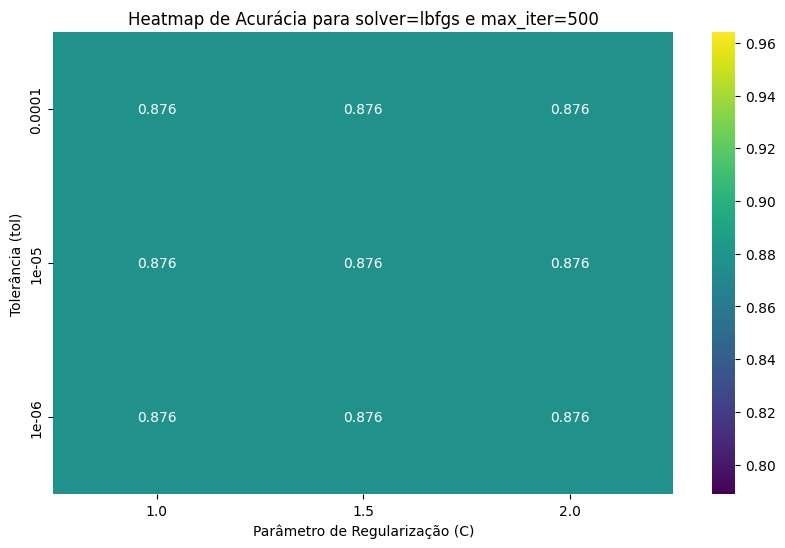

In [34]:
# Resultados do GridSearchCV
resultados_LR = grid_search.cv_results_

# Escolher um valor fixo para solver e max_iter
solver_value = 'lbfgs'  # Escolha um valor fixo de solver
max_iter_value = 500     # Escolha um valor fixo de max_iter

# Filtrar os resultados com base no solver e max_iter escolhidos
mask = (resultados_LR['param_solver'] == solver_value) & (resultados_LR['param_max_iter'] == max_iter_value)

# Extraindo as pontuações médias para o heatmap
mean_scores = np.array(resultados_LR['mean_test_score'])[mask]

# Reshape dos scores para ajustar aos parâmetros tol e C
scores = mean_scores.reshape(len(parametros['tol']), len(parametros['C']))

# Criar o heatmap para visualizar tol vs C com o solver e max_iter fixos
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=parametros['C'], yticklabels=parametros['tol'], cmap='viridis')
plt.title(f"Heatmap de Acurácia para solver={solver_value} e max_iter={max_iter_value}")
plt.xlabel('Parâmetro de Regularização (C)')
plt.ylabel('Tolerância (tol)')
plt.show()


### SVM

In [51]:
parametros = {  # Define um dicionário chamado 'parametros' para armazenar as combinações de hiperparâmetros a serem testadas
    'tol': [0.001, 0.0001, 0.00001],  # Tolerância para o critério de parada. Valores menores significam convergência mais precisa
    'C': [0.1, 0.5, 1],  # Parâmetro de regularização. Valores menores especificam uma regularização mais forte
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Tipo de função kernel a ser usada pelo SVM
}

In [52]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)  # Cria o GridSearchCV com SVC como estimador e o dicionário 'parametros' como grade de hiperparâmetros
grid_search.fit(x_mushroom, y_mushroom)  # Ajusta o grid_search aos dados de treinamento, buscando a melhor combinação de hiperparâmetros
melhores_parametros = grid_search.best_params_  # Obtém os melhores hiperparâmetros encontrados pelo GridSearchCV
melhor_resultado = grid_search.best_score_  # Obtém a melhor pontuação de desempenho alcançada durante a busca
print(melhores_parametros)  # Imprime os melhores hiperparâmetros
print(melhor_resultado)  # Imprime a melhor pontuação de desempenho (acurácia)


{'C': 1, 'kernel': 'rbf', 'tol': 0.001}
0.9847361121636984


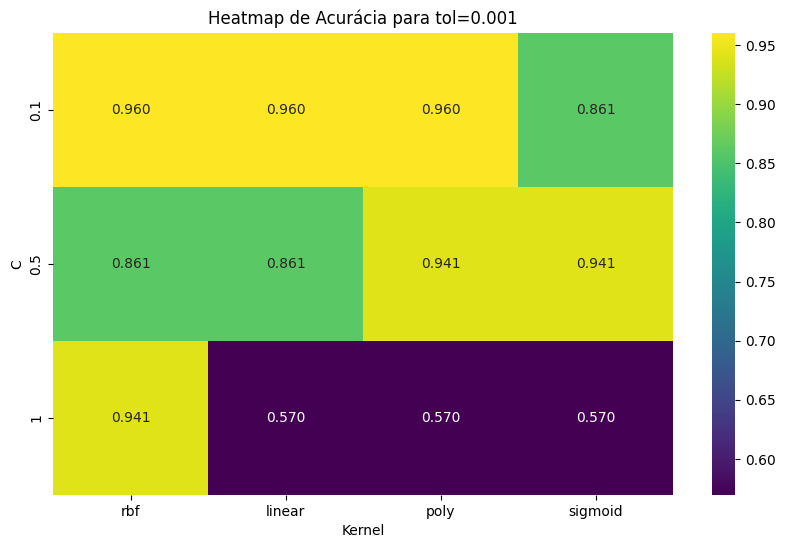

In [53]:
# Obter os resultados do GridSearchCV
resultados_SVM = grid_search.cv_results_

# Reshape considerando os 3 parâmetros (tol, C, kernel)
scores = np.array(resultados_SVM['mean_test_score']).reshape(len(parametros['tol']), len(parametros['C']), len(parametros['kernel']))

# Identificar o índice correspondente ao valor de tol=0.001
tol_index = parametros['tol'].index(0.001)

# Plotar o heatmap apenas para tol=0.001
plt.figure(figsize=(10, 6))
sns.heatmap(scores[tol_index], annot=True, fmt=".3f", xticklabels=parametros['kernel'], yticklabels=parametros['C'], cmap='viridis')
plt.title(f"Heatmap de Acurácia para tol=0.001")
plt.xlabel('Kernel')
plt.ylabel('C')
plt.show()


### Redes Neurais

In [145]:
parametros = {  # Define um dicionário chamado 'parametros' para armazenar as combinações de hiperparâmetros a serem testadas
    'activation': ['relu', 'logistic', 'tanh'],  # Função de ativação a ser usada nas camadas ocultas ('relu', 'logistic', 'tanh')
    'solver': ['adam', 'sgd'],  # Algoritmo para otimização do modelo ('adam', 'sgd')
    'batch_size': [10, 560],  # Tamanho do lote para atualização dos gradientes
    'max_iter': [500, 1000]  # Aumentando o número de iterações para garantir a convergência
}

In [146]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=parametros)  # Cria o GridSearchCV com MLPClassifier e a grade de hiperparâmetros
grid_search.fit(x_mushroom, y_mushroom)  # Ajusta o grid_search aos dados de treinamento, realizando a busca exaustiva de hiperparâmetros
melhores_parametros = grid_search.best_params_  # Obtém os melhores hiperparâmetros encontrados pelo GridSearchCV
melhor_resultado = grid_search.best_score_  # Obtém a melhor pontuação de desempenho alcançada durante a busca
print(melhores_parametros)  # Imprime os melhores hiperparâmetros
print(melhor_resultado)  # Imprime a melhor pontuação de desempenho (acurácia)

{'activation': 'relu', 'batch_size': 10, 'max_iter': 500, 'solver': 'adam'}
1.0


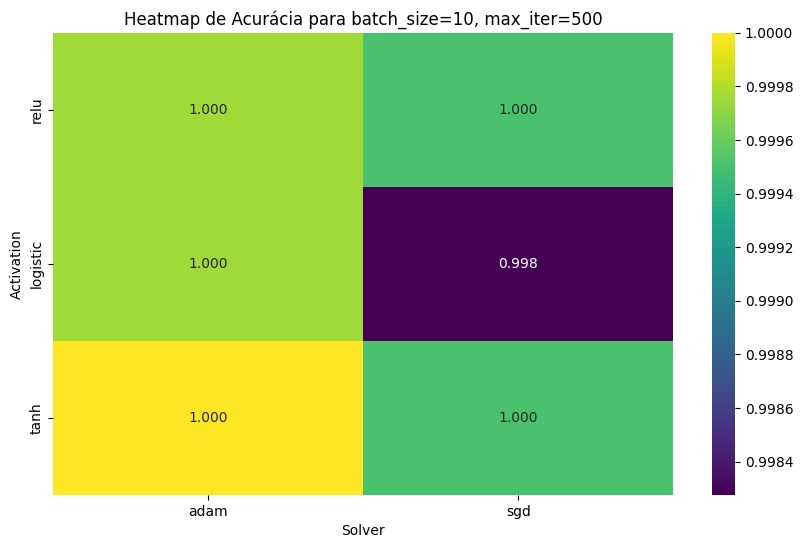

In [56]:
resultados_mlp = grid_search.cv_results_

# Filtrar os resultados apenas para batch_size = 10 e max_iter = 500
batch_size_index = parametros['batch_size'].index(10)  # Índice para batch_size = 10
max_iter_index = parametros['max_iter'].index(500)  # Índice para max_iter = 500

# Reshape considerando apenas os parâmetros 'activation' e 'solver' para os valores fixos de batch_size e max_iter
scores = np.array(resultados_mlp['mean_test_score']).reshape(
    len(parametros['activation']), len(parametros['solver']), len(parametros['batch_size']), len(parametros['max_iter'])
)

# Selecionar os scores específicos para batch_size = 10 e max_iter = 500
selected_scores = scores[:, :, batch_size_index, max_iter_index]

# Plotar o heatmap para a combinação de batch_size = 10 e max_iter = 500
plt.figure(figsize=(10, 6))
sns.heatmap(selected_scores, annot=True, fmt=".3f", xticklabels=parametros['solver'], yticklabels=parametros['activation'], cmap='viridis')
plt.title(f"Heatmap de Acurácia para batch_size=10, max_iter=500")
plt.xlabel('Solver')
plt.ylabel('Activation')
plt.show()


### Validação Cruzada

In [161]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Inicialização de listas para armazenar os resultados das avaliações dos modelos
resultados_arvore = []  # Lista para armazenar os resultados da Árvore de Decisão
resultados_random_forest = []  # Lista para armazenar os resultados do Random Forest
resultados_knn = []  # Lista para armazenar os resultados do KNN
resultados_logistica = []  # Lista para armazenar os resultados da Regressão Logística
resultados_svm = []  # Lista para armazenar os resultados do SVM
resultados_rede_neural = []  # Lista para armazenar os resultados da Rede Neural

# Loop para realizar a validação cruzada 30 vezes com diferentes seeds
for i in range(30):
    print(i)  # Imprime o número da iteração atual

    # Criação do KFold com 10 divisões, embaralhando os dados e utilizando uma seed diferente a cada iteração
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)  # Cria uma instância do KFold para a validação cruzada

    # Avaliação da Árvore de Decisão
    arvore = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2, splitter='best')  # Define o modelo de Árvore de Decisão com hiperparâmetros ajustados
    scores = cross_val_score(arvore, x_mushroom, y_mushroom, cv=kfold)  # Executa a validação cruzada e armazena as acurácias
    resultados_arvore.append(scores.mean())  # Calcula e armazena a média das acurácias

    # Avaliação do Random Forest
    random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2, n_estimators=10)  # Define o modelo Random Forest com hiperparâmetros ajustados
    scores = cross_val_score(random_forest, x_mushroom, y_mushroom, cv=kfold)  # Executa a validação cruzada e armazena as acurácias
    resultados_random_forest.append(scores.mean())  # Calcula e armazena a média das acurácias

    # Avaliação do KNN
    knn = KNeighborsClassifier(n_neighbors=3, p=1)  # Define o modelo KNN com hiperparâmetros ajustados
    scores = cross_val_score(knn, x_mushroom, y_mushroom, cv=kfold)  # Executa a validação cruzada e armazena as acurácias
    resultados_knn.append(scores.mean())  # Calcula e armazena a média das acurácias

    # Avaliação da Regressão Logística
    logistica = LogisticRegression(C=1.0, max_iter=500, solver='lbfgs', tol=0.0001)  # Define o modelo de Regressão Logística com hiperparâmetros ajustados
    scores = cross_val_score(logistica, x_mushroom, y_mushroom, cv=kfold)  # Executa a validação cruzada e armazena as acurácias
    resultados_logistica.append(scores.mean())  # Calcula e armazena a média das acurácias

    # Avaliação do SVM
    svm = SVC(C=1, kernel='rbf', tol=0.001)  # Define o modelo SVM com hiperparâmetros ajustados
    scores = cross_val_score(svm, x_mushroom, y_mushroom, cv=kfold)  # Executa a validação cruzada e armazena as acurácias
    resultados_svm.append(scores.mean())  # Calcula e armazena a média das acurácias

    # Avaliação da Rede Neural (ajuste manual, resultados esperados a serem incluídos)
    rede_neural = MLPClassifier(activation='relu', batch_size=10, solver='adam', max_iter=500)  # Define o modelo de Rede Neural com hiperparâmetros ajustados
    scores = cross_val_score(rede_neural, x_mushroom, y_mushroom, cv=kfold)  # Executa a validação cruzada e armazena as acurácias
    resultados_rede_neural.append(scores.mean())  # Calcula e armazena a média das acurácias

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [162]:
# Criação de um DataFrame com os resultados das validações cruzadas
resultados = pd.DataFrame({
    'Arvore': resultados_arvore,  # Coluna com os resultados da Árvore de Decisão
    'Random forest': resultados_random_forest,  # Coluna com os resultados do Random Forest
    'KNN': resultados_knn,  # Coluna com os resultados do KNN
    'Logistica': resultados_logistica,  # Coluna com os resultados da Regressão Logística
    'SVM': resultados_svm,  # Coluna com os resultados do SVM
    'Rede neural': resultados_rede_neural  # Coluna com os resultados da Rede Neural
})

# Exibição do DataFrame contendo os resultados
resultados  # Exibe o DataFrame na saída, mostrando a média das acurácias para cada modelo em cada iteração

,Arvore,Random forest,KNN,Logistica,SVM,Rede neural
0,1.000000,1.000000,0.999877,0.876416,0.990520,0.998892
1,1.000000,1.000000,0.999877,0.876416,0.990030,0.999754
2,1.000000,1.000000,0.999631,0.876413,0.990152,0.998646
3,1.000000,1.000000,1.000000,0.876417,0.989168,0.999877
4,1.000000,1.000000,1.000000,0.876413,0.988428,0.998769
5,1.000000,1.000000,1.000000,0.876416,0.990028,0.999877
6,1.000000,0.999877,1.000000,0.876415,0.992244,0.999631
7,1.000000,1.000000,1.000000,0.876418,0.991017,0.999385
8,1.000000,1.000000,1.000000,0.876409,0.989905,1.000000
9,1.000000,1.000000,1.000000,0.876413,0.990644,0.999631


In [59]:
resultados.describe()

,Arvore,Random forest,KNN,Logistica,SVM,Rede neural
count,30.0,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.0,0.999984,0.999934,0.876415,0.991039,0.999635
std,0.0,0.000062,0.000128,0.000002,0.001129,0.000329
min,1.0,0.999754,0.999507,0.876411,0.987813,0.998892
25%,1.0,1.000000,0.999877,0.876413,0.990430,0.999508
50%,1.0,1.000000,1.000000,0.876415,0.991260,0.999754
75%,1.0,1.000000,1.000000,0.876416,0.991815,0.999877
max,1.0,1.000000,1.000000,0.876419,0.992860,1.000000


In [60]:
# Calcula e exibe a variância dos resultados das validações cruzadas para cada modelo
# Baixa variância indica desempenho consistente e previsível do modelo, com variações mínimas nas acurácias entre as iterações.
# Alta variância sugere sensibilidade a pequenas mudanças nos dados ou hiperparâmetros, levando a um desempenho menos estável e mais variável durante as iterações da validação cruzada.
resultados.var()

Arvore           0.000000e+00
Random forest    3.904961e-09
KNN              1.644531e-08
Logistica        4.583502e-12
SVM              1.275214e-06
Rede neural      1.081776e-07
dtype: float64

In [61]:
# Calcula e exibe o Coeficiente de Variação (CV) dos resultados das validações cruzadas para cada modelo, em percentual
(resultados.std() / resultados.mean()) * 100

Arvore           0.000000
Random forest    0.006249
KNN              0.012825
Logistica        0.000244
SVM              0.113946
Rede neural      0.032902
dtype: float64

### Teste de normalidade nos resultados

In [158]:
# Valor p > 0.05: os dados são normais.
# Valor p ≤ 0.05: os dados não são normais.
alpha = 0.05

In [163]:
import warnings
from scipy.stats import shapiro

# Suprime warnings relacionados ao scipy.stats.shapiro
warnings.filterwarnings('ignore', category=UserWarning, module='scipy.stats')

shapiro(resultados_arvore), shapiro(resultados_random_forest), shapiro(resultados_knn), shapiro(resultados_logistica), shapiro(resultados_svm), shapiro(resultados_rede_neural)

(ShapiroResult(statistic=np.float64(0.27338863845597294), pvalue=np.float64(4.239416616444376e-11)),
 ShapiroResult(statistic=np.float64(0.2734380812981837), pvalue=np.float64(4.243378800637372e-11)),
 ShapiroResult(statistic=np.float64(0.5369081172777153), pvalue=np.float64(1.345667957232337e-08)),
 ShapiroResult(statistic=np.float64(0.9500870145893647), pvalue=np.float64(0.16996992117014237)),
 ShapiroResult(statistic=np.float64(0.9586797739647646), pvalue=np.float64(0.28650201946138265)),
 ShapiroResult(statistic=np.float64(0.8173129208190051), pvalue=np.float64(0.0001378466335832429)))

### Análise dos Resultados dos Testes de Shapiro-Wilk:

- **Árvore de Decisão:** p-value = 4.2396e-11 (resíduos muito distantes da normalidade)
- **Random Forest:** p-value = 4.2432e-11 (resíduos longe da normalidade)
- **KNN:** p-value = 1.3457e-08 (resíduos ainda distantes da normalidade)
- **Regressão Logística:** p-value = 0.1699 (resíduos razoavelmente próximos da normalidade)
- **SVM:** p-value = 0.2865 (resíduos mais próximos da normalidade)
- **Rede Neural:** p-value = 0.0001 (resíduos distantes da normalidade)

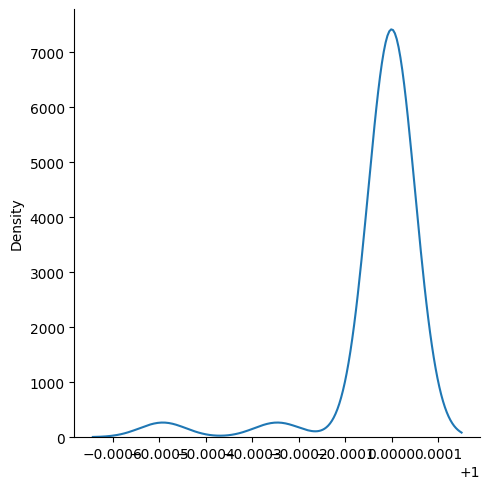

In [164]:
sns.displot(resultados_arvore, kind='kde', warn_singular=False)


In [165]:
# Criar um DataFrame para organizar os resultados
df_resultados_arvore = pd.DataFrame(resultados_arvore, columns=['Resultados Árvore de Decisão'])

# Exibir o DataFrame em formato de tabela
print(df_resultados_arvore)

    Resultados Árvore de Decisão
0                       1.000000
1                       1.000000
2                       1.000000
3                       1.000000
4                       1.000000
5                       1.000000
6                       1.000000
7                       1.000000
8                       1.000000
9                       1.000000
10                      1.000000
11                      1.000000
12                      1.000000
13                      0.999754
14                      1.000000
15                      1.000000
16                      1.000000
17                      1.000000
18                      1.000000
19                      1.000000
20                      0.999507
21                      1.000000
22                      1.000000
23                      1.000000
24                      1.000000
25                      1.000000
26                      1.000000
27                      1.000000
28                      1.000000
29        

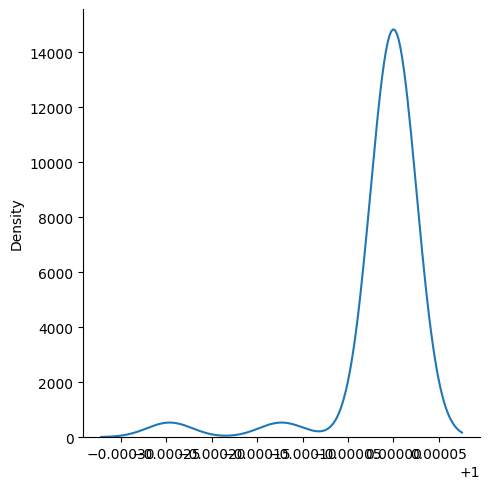

In [166]:
sns.displot(resultados_random_forest, kind= 'kde')

In [167]:
# Criar um DataFrame para organizar os resultados
df_resultados_random_forest = pd.DataFrame(resultados_random_forest, columns=['Resultados Random Forest'])

# Exibir o DataFrame em formato de tabela
print(df_resultados_random_forest)

    Resultados Random Forest
0                   1.000000
1                   1.000000
2                   1.000000
3                   1.000000
4                   1.000000
5                   1.000000
6                   0.999877
7                   1.000000
8                   1.000000
9                   1.000000
10                  1.000000
11                  1.000000
12                  1.000000
13                  1.000000
14                  1.000000
15                  1.000000
16                  1.000000
17                  1.000000
18                  1.000000
19                  1.000000
20                  0.999754
21                  1.000000
22                  1.000000
23                  1.000000
24                  1.000000
25                  1.000000
26                  1.000000
27                  1.000000
28                  1.000000
29                  1.000000


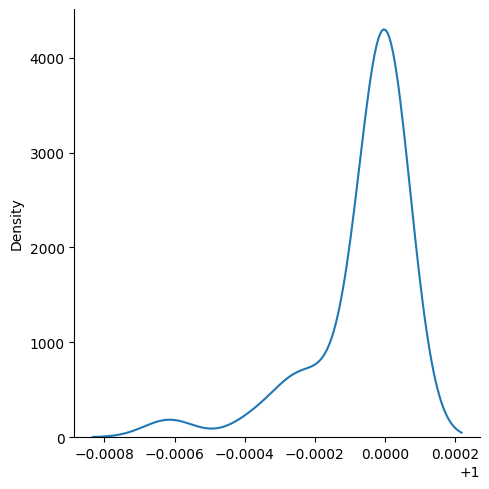

In [168]:
sns.displot(resultados_knn, kind= 'kde')

In [169]:
# Criar um DataFrame para organizar os resultados
df_resultados_knn = pd.DataFrame(resultados_knn, columns=['Resultados KNN'])

# Exibir o DataFrame em formato de tabela
print(df_resultados_knn)

    Resultados KNN
0         0.999877
1         0.999877
2         0.999631
3         1.000000
4         1.000000
5         1.000000
6         1.000000
7         1.000000
8         1.000000
9         1.000000
10        1.000000
11        1.000000
12        1.000000
13        1.000000
14        1.000000
15        1.000000
16        1.000000
17        1.000000
18        1.000000
19        1.000000
20        0.999754
21        1.000000
22        1.000000
23        0.999385
24        1.000000
25        0.999754
26        1.000000
27        1.000000
28        0.999754
29        1.000000


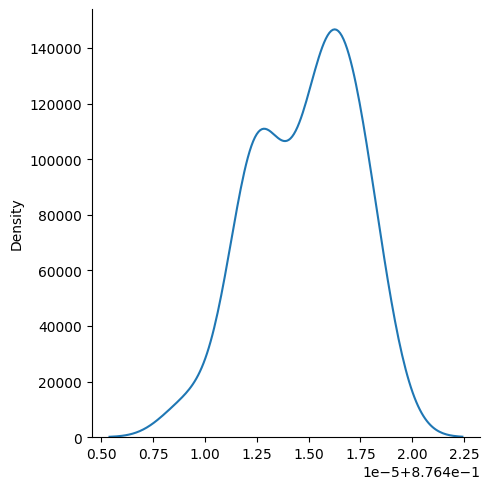

In [170]:
sns.displot(resultados_logistica, kind= 'kde')

In [171]:
# Criar um DataFrame para organizar os resultados
df_resultados_logistica = pd.DataFrame(resultados_logistica, columns=['Resultados Regressão Logistica'])

# Exibir o DataFrame em formato de tabela
print(df_resultados_logistica)

    Resultados Regressão Logistica
0                         0.876416
1                         0.876416
2                         0.876413
3                         0.876417
4                         0.876413
5                         0.876416
6                         0.876415
7                         0.876418
8                         0.876409
9                         0.876413
10                        0.876412
11                        0.876413
12                        0.876416
13                        0.876417
14                        0.876412
15                        0.876412
16                        0.876419
17                        0.876415
18                        0.876416
19                        0.876413
20                        0.876418
21                        0.876418
22                        0.876416
23                        0.876411
24                        0.876417
25                        0.876415
26                        0.876413
27                  

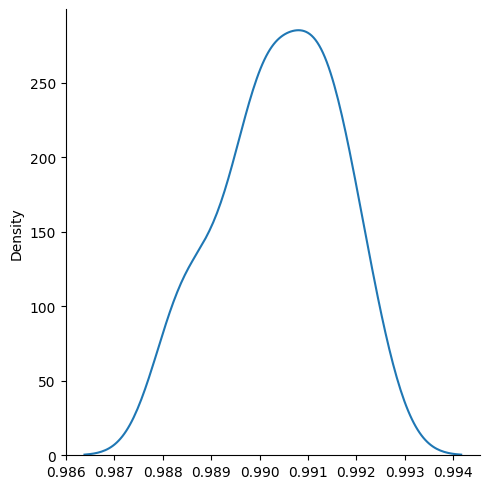

In [172]:
sns.displot(resultados_svm, kind= 'kde')

In [173]:
# Criar um DataFrame para organizar os resultados
df_resultados_svm = pd.DataFrame(resultados_svm, columns=['Resultados SVM'])

# Exibir o DataFrame em formato de tabela
print(df_resultados_svm)

    Resultados SVM
0         0.990520
1         0.990030
2         0.990152
3         0.989168
4         0.988428
5         0.990028
6         0.992244
7         0.991017
8         0.989905
9         0.990644
10        0.991383
11        0.991015
12        0.988429
13        0.990398
14        0.988428
15        0.991997
16        0.991138
17        0.989413
18        0.991138
19        0.992368
20        0.989167
21        0.991628
22        0.991630
23        0.991139
24        0.990152
25        0.990031
26        0.988181
27        0.991753
28        0.989784
29        0.991260


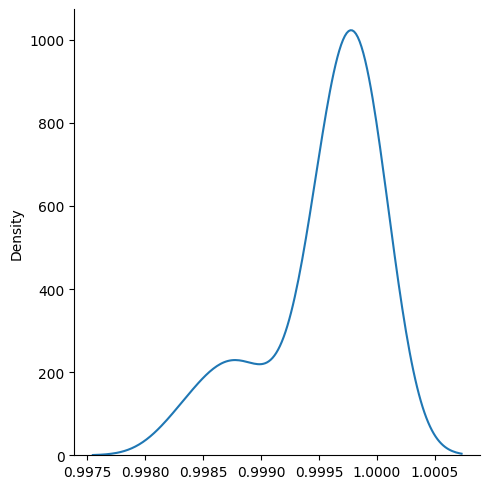

In [174]:
sns.displot(resultados_rede_neural, kind= 'kde')

In [175]:
# Criar um DataFrame para organizar os resultados
df_resultados_rede_neural = pd.DataFrame(resultados_rede_neural, columns=['Resultados Redes Neurais'])

# Exibir o DataFrame em formato de tabela
print(df_resultados_rede_neural)

    Resultados Redes Neurais
0                   0.998892
1                   0.999754
2                   0.998646
3                   0.999877
4                   0.998769
5                   0.999877
6                   0.999631
7                   0.999385
8                   1.000000
9                   0.999631
10                  0.998523
11                  1.000000
12                  0.999877
13                  0.999015
14                  0.999385
15                  0.999877
16                  0.999754
17                  0.999877
18                  1.000000
19                  1.000000
20                  0.999631
21                  0.999877
22                  0.998277
23                  1.000000
24                  0.999508
25                  0.999631
26                  0.999631
27                  0.999631
28                  0.999754
29                  0.999631


In [116]:
# Separamos 20% para o teste
entradas_treino, entradas_teste, categoria_treino, categoria_teste = train_test_split(entradas, categoria, test_size=0.2)

print(f"Formato das tabelas de dados de treino {entradas_treino.shape} e teste {entradas_teste.shape}")

Formato das tabelas de dados de treino (6499, 8) e teste (1625, 8)


In [117]:
# Primeiras linhas do dataframe de entradas_treino
entradas_treino.head()

,forma-do-caule,raiz-do-caule,odor,habitat,cor-do-chapéu,forma-do-chapéu,número-do-anel,cor-do-velo
4195,1,0,6,6,7,3,1,2
7737,0,6,6,1,0,4,1,0
4392,0,0,4,0,9,3,1,2
1920,1,0,6,6,7,2,1,2
411,1,3,6,0,0,2,1,2


In [118]:
# Primeiras linhas do dataframe de categoria_treino
categoria_treino.head()

4195    1
7737    1
4392    2
1920    1
411     1
Name: classe, dtype: int64

In [119]:
# Criando e treinando o modelo SVM
modelo_svm = SVC(C=1.0, kernel='rbf', tol=0.001)  # Esses são os melhores hiperparâmetros que você encontrou
modelo_svm.fit(entradas_treino, categoria_treino)


SVC()

In [120]:
# Certifique-se de que o modelo foi treinado
categoria_encontradas = modelo_svm.predict(entradas_teste)
print("Predição: {}".format(categoria_encontradas))

Predição: [2 1 1 ... 1 1 2]


In [121]:
# Para determinar a quantidade de acertos (acuracia)
acertos = accuracy_score(categoria_teste, categoria_encontradas)
print("Acerto médio de classificação: ", acertos)

Acerto médio de classificação:  0.9926153846153846


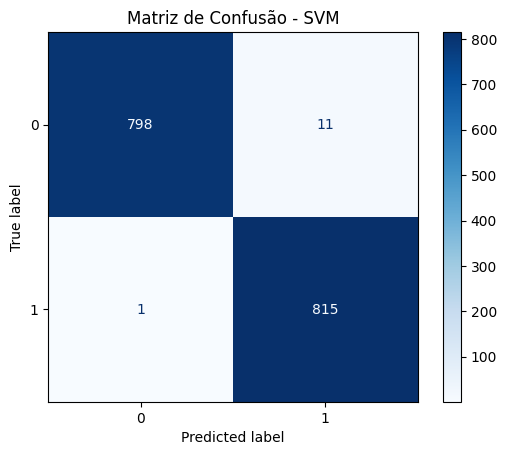

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Gerar a matriz de confusão
matriz_confusao = confusion_matrix(categoria_teste, categoria_encontradas)

# Exibir a matriz de confusão usando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - SVM')
plt.show()

#### **Testando classificação da categoria do cogumelo, se será (COMESTÍVEL = 1) ou (VENENOSO = 2)**

### No modelo de teste inserimos os seguintes dados para análise:

- Forma do Caule (1 = t): Afunilando – o caule se afunila à medida que cresce.

- Raiz do Caule (4 = r): Enraizado – base do caule está fortemente enraizada.

- Odor (2 = l): Anis – odor semelhante a anis.

- Habitat (4 = u): Urbano – encontrado em áreas urbanas.

- Cor do Chapéu (1 = b): Creme – chapéu de cor creme.

- Forma do Chapéu (1 = c): Cônico – chapéu com formato cônico.

- Número do Anel (3 = t): Dois – possui dois anéis no caule.

- Cor do Velo (2 = w): Branco – cor do velo é branca.

In [123]:
# Teste 1
Test = pd.DataFrame([[1, 4, 2, 4, 1, 1, 3, 2]], columns=['forma-do-caule', 'raiz-do-caule', 'odor','habitat', 'cor-do-chapéu', 'forma-do-chapéu', 'número-do-anel','cor-do-velo'])
previsao = modelo_svm.predict(Test)
print("Previsão:", previsao)

Previsão: [1]


#### **Testando classificação da categoria do cogumelo, se será (COMESTÍVEL = 1) ou (VENENOSO = 2)**

### No modelo de teste inserimos os seguintes dados para análise:

- Forma do Caule (0 = e): Alargando – o caule se alarga à medida que cresce.

- Raiz do Caule (0 = b): Bulbosa – base do caule em formato de bulbo.

- Odor (5 = m): Mofado – odor de mofo.

- Habitat (4 = u): Urbano – encontrado em áreas urbanas.

- Cor do Chapéu (4 = e): Verde – chapéu esverdeado.

- Forma do Chapéu (0 = b): Sino – chapéu em forma de sino.

- Número do Anel (0 = n): Nenhum – sem anéis no caule.

- Cor do Velo (1 = o): Laranja – cor do velo é laranja.

In [124]:
# Teste 2
Test = pd.DataFrame([[0, 0, 5, 4, 4, 0, 0, 1]], columns=['forma-do-caule', 'raiz-do-caule', 'odor','habitat', 'cor-do-chapéu', 'forma-do-chapéu', 'número-do-anel','cor-do-velo'])
previsao = modelo_svm.predict(Test)
print("Previsão:", previsao)

Previsão: [2]


In [127]:
# Salva o modelo treinado
joblib.dump(modelo_svm, 'modelo_svm.pkl')

['modelo_svm.pkl']